Submission Proyek Pertama: Membuat Model NLP dengan Tensorflow. 

Kelas Belajar Pengembangan Machine Learning by Dicoding. 
<br>
<br>
<br>
Nama: Andi Abdul Hafez Ramadhan

Email: etchzel@gmail.com

Mount google drive ke colab

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


Import library untuk pengolahan zipfile dan direktori, set direktori dasar

In [1]:
import os
import zipfile

base_dir = '/content/drive/MyDrive/Kaggle'
os.environ['KAGGLE_CONFIG_DIR'] = base_dir

In [2]:
%cd "$base_dir"

/content/drive/MyDrive/Kaggle


Download dataset dari Kaggle menggunakan Kaggle API.

Token authorization untuk Kaggle API sudah terlebih dahulu diletakkan di direktori MyDrive/Kaggle.



Link dataset: https://www.kaggle.com/hgultekin/bbcnewsarchive

In [3]:
!kaggle datasets download -d hgultekin/bbcnewsarchive

  0% 0.00/1.81M [00:00<?, ?B/s]
100% 1.81M/1.81M [00:00<00:00, 59.7MB/s]


In [4]:
!ls

 bbcnewsarchive.zip		    kaggle.json
 Citrus				    news-category-dataset
 covid-19-nlp-text-classification  'sentiment labelled sentences'
 imdb-synopsis-indonesian-movies


Buat direktori untuk menyimpan dataset yang baru di download, lalu hapus zip file nya.

In [5]:
#function that creates the folder for the dataset zip file we just downloaded
def create_dataset_dir(folder_name):
  try:
    os.mkdir(folder_name)
    print('Directory ', folder_name, ' created')
  except FileExistsError:
    print('Directory ', folder_name, ' already exists!')

In [6]:
for filename in os.listdir(base_dir):
  if filename.endswith('.zip'):
    local_zip = filename
    folder_name = os.path.splitext(local_zip)[0]
    create_dataset_dir(folder_name)

    with zipfile.ZipFile(local_zip, 'r') as zip:
      zip.printdir()
      print('Extracting all the files now...')
      zip.extractall(os.path.join(
          base_dir,
          folder_name
      ))
      print('Done!')

Directory  bbcnewsarchive  created
File Name                                             Modified             Size
bbc-news-data.csv                              2020-07-31 15:06:56      5080260
Extracting all the files now...
Done!


In [7]:
!rm "$local_zip"

In [3]:
#reset variables just in case runtime dc so
#no need to go through the whole process above
local_zip = 'bbcnewsarchive.zip'
folder_name = os.path.splitext(local_zip)[0]

Ganti working directory ke folder dataset

In [4]:
%cd "$folder_name"

/content/drive/MyDrive/Kaggle/bbcnewsarchive


Import semua library yang diperlukan

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import string
import re
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import Callback, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.layers \
import Embedding, LSTM, Dense, Dropout, Bidirectional

Load dataset ke dataframe pandas, separator tab digunakan sesuai spesifikasi di deskripsi source dataset.

In [6]:
filename = os.listdir()[0]

In [7]:
df = pd.read_csv(filename, sep='\t')

In [8]:
df

,category,filename,title,content
0,business,001.txt,Ad sales boost Time Warner profit,Quarterly profits at US media giant TimeWarne...
1,business,002.txt,Dollar gains on Greenspan speech,The dollar has hit its highest level against ...
2,business,003.txt,Yukos unit buyer faces loan claim,The owners of embattled Russian oil giant Yuk...
3,business,004.txt,High fuel prices hit BA's profits,British Airways has blamed high fuel prices f...
4,business,005.txt,Pernod takeover talk lifts Domecq,Shares in UK drinks and food firm Allied Dome...
...,...,...,...,...
2220,tech,397.txt,BT program to beat dialler scams,BT is introducing two initiatives to help bea...
2221,tech,398.txt,Spam e-mails tempt net shoppers,Computer users across the world continue to i...
2222,tech,399.txt,Be careful how you code,A new European directive could put software w...
2223,tech,400.txt,US cyber security chief resigns,The man making sure US computer networks are ...


In [35]:
print('Total samples: {}'.format(df.shape[0]))

Total samples: 2225


In [9]:
#Check for missing values
df.isnull().sum()

category    0
filename    0
title       0
content     0
dtype: int64

Drop kolom yang tidak diperlukan. Kolom yang relevan hanya kolom content dan category.

In [10]:
df.columns.to_list()[1:3]

['filename', 'title']

In [11]:
drop_columns = df.columns.to_list()[1:3]
df.drop(columns=drop_columns, inplace=True)

In [12]:
df

,category,content
0,business,Quarterly profits at US media giant TimeWarne...
1,business,The dollar has hit its highest level against ...
2,business,The owners of embattled Russian oil giant Yuk...
3,business,British Airways has blamed high fuel prices f...
4,business,Shares in UK drinks and food firm Allied Dome...
...,...,...
2220,tech,BT is introducing two initiatives to help bea...
2221,tech,Computer users across the world continue to i...
2222,tech,A new European directive could put software w...
2223,tech,The man making sure US computer networks are ...


Proses data cleaning dengan menghapus stopwords, punctuation, dll.

In [13]:
#download the stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [14]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [15]:
#function to clean the data
def clean_data(txt):
  #lowercase all the text
  txt = txt.lower()

  #removing stopwords
  txt = ' '.join(
      [word for word in txt.split() 
      if not word in set(stopwords.words('english'))]
  )

  #removing punctuations
  for punctuation in string.punctuation:
    txt = txt.replace(punctuation, ' ')

  #removing html tags, double spaces, tabs, and numbers
  regex_list = [r'/<.*?>/g', r'/\s\s+/g', r'/\t+/g', r'/\d+/g']
  for regex in regex_list:
    txt = re.sub(regex, ' ', txt)

  #returns lowercase version of the string
  return txt.lower()

In [16]:
df_cleaned = df.copy(deep=True)

In [17]:
df_cleaned.content = df_cleaned.content.apply(
    lambda x: clean_data(x)
)

In [18]:
df_cleaned

,category,content
0,business,quarterly profits us media giant timewarner ju...
1,business,dollar hit highest level euro almost three mon...
2,business,owners embattled russian oil giant yukos ask b...
3,business,british airways blamed high fuel prices 40 dr...
4,business,shares uk drinks food firm allied domecq risen...
...,...,...
2220,tech,bt introducing two initiatives help beat rogue...
2221,tech,computer users across world continue ignore se...
2222,tech,new european directive could put software writ...
2223,tech,man making sure us computer networks safe secu...


Buat one-hot encoding dari label class kolom category. Jumlah class: 5.

In [19]:
class_labels = pd.get_dummies(df_cleaned.category)
class_labels

,business,entertainment,politics,sport,tech
0,1,0,0,0,0
1,1,0,0,0,0
2,1,0,0,0,0
3,1,0,0,0,0
4,1,0,0,0,0
...,...,...,...,...,...
2220,0,0,0,0,1
2221,0,0,0,0,1
2222,0,0,0,0,1
2223,0,0,0,0,1


In [20]:
label = class_labels.values

Kolom content digunakan sebagai data.

In [21]:
data = df_cleaned.content.values

Bagi data menjadi train dan validation set dimana validation set sebesar 20% dari total data.

In [22]:
data_train, data_validation, label_train, label_validation = train_test_split(
    data,
    label,
    test_size=0.2,
    shuffle=True,
    stratify=label
)

In [38]:
print('Total training data: {}'.format(data_train.shape[0]))
print('Total validation data: {}'.format(data_validation.shape[0]))

Total training data: 1780
Total validation data: 445


Buat tokenizer menggunakan data yang sudah di split.

In [23]:
tokenizer = Tokenizer(num_words=30000, oov_token='oov')

In [24]:
tokenizer.fit_on_texts(data_train)
tokenizer.fit_on_texts(data_validation)

In [25]:
INPUT_DIM = len(tokenizer.word_index)+1
print(INPUT_DIM)

29577


Buat sequence dari tokenized text sebelumnya.

In [26]:
sequence_train = tokenizer.texts_to_sequences(data_train)
sequence_validation = tokenizer.texts_to_sequences(data_validation)

Padding sequence.

In [27]:
padded_train = pad_sequences(
    sequence_train,
    maxlen=256
)

padded_validation = pad_sequences(
    sequence_validation,
    maxlen=256
)

Buat model sequential untuk training data. BiLSTM layer digunakan setelah embedding.

In [28]:
model = tf.keras.Sequential([
    Embedding(
        input_dim=INPUT_DIM,
        output_dim=32,
        input_length=256
    ),
    Bidirectional(LSTM(64, dropout=0.2)),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(5, activation='softmax')
])

In [29]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)

In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 256, 32)           946464    
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               49664     
_________________________________________________________________
dense (Dense)                (None, 128)               16512     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 645       
Total params: 1,013,285
Trainable params: 1,013,285
Non-trainable params: 0
_________________________________________________________________


Buat list callbacks. Callbacks yang digunakan adalah:

ReduceLROnPlateau digunakan untuk mengurangi learning rate ketika validation loss tidak menurun dalam beberapa (3) epochs.

EarlyStopping digunakan untuk stop training jika validation accuracy tidak meningkat dalam beberapa (10) epochs.

In [31]:
callbacks = [
    ReduceLROnPlateau(monitor='val_loss',factor=0.5,patience=3,verbose=1), 
    EarlyStopping(monitor='val_accuracy', patience=10, verbose=1, baseline=0.9)
]

Fit training data ke model.

In [32]:
history = model.fit(
    padded_train,
    label_train,
    epochs=50,
    validation_data=(padded_validation,label_validation),
    callbacks=callbacks,
    verbose=1
)

Epoch 1/50
56/56 [==============================] - 18s 263ms/step - loss: 1.5759 - accuracy: 0.2522 - val_loss: 1.5276 - val_accuracy: 0.4090
Epoch 2/50
56/56 [==============================] - 14s 246ms/step - loss: 1.2422 - accuracy: 0.4837 - val_loss: 0.9329 - val_accuracy: 0.7011
Epoch 3/50
56/56 [==============================] - 14s 252ms/step - loss: 0.7501 - accuracy: 0.7433 - val_loss: 0.5730 - val_accuracy: 0.7820
Epoch 4/50
56/56 [==============================] - 14s 253ms/step - loss: 0.2741 - accuracy: 0.9101 - val_loss: 0.1969 - val_accuracy: 0.9326
Epoch 5/50
56/56 [==============================] - 14s 254ms/step - loss: 0.0777 - accuracy: 0.9820 - val_loss: 0.2793 - val_accuracy: 0.9056
Epoch 6/50
56/56 [==============================] - 14s 253ms/step - loss: 0.0391 - accuracy: 0.9921 - val_loss: 0.2006 - val_accuracy: 0.9371
Epoch 7/50
56/56 [==============================] - 14s 253ms/step - loss: 0.0254 - accuracy: 0.9921 - val_loss: 0.4320 - val_accuracy: 0.8899

Buat fungsi untuk plot akurasi dan loss metrics.

In [66]:
%matplotlib inline

def metrics_graph(history, metrics):
  val_metrics = 'val_'+metrics
  plt.plot(history.history[metrics])
  plt.plot(history.history[val_metrics])
  plt.xlabel('Epochs')
  plt.ylabel(metrics.capitalize())
  plt.title('Model '+metrics)
  plt.legend([metrics, val_metrics])
  plt.grid(True)
  plt.show()

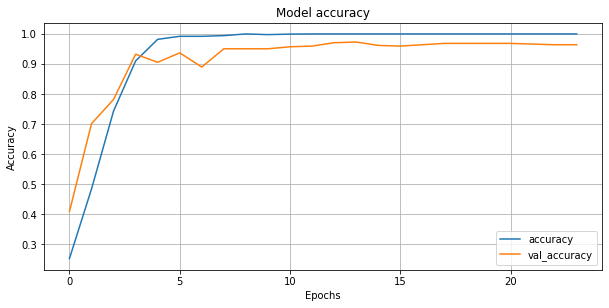

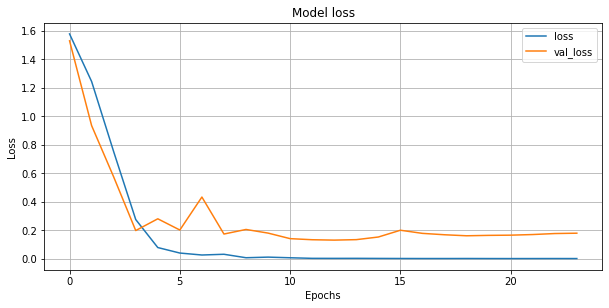

In [71]:
plt.figure(figsize=(10,10))
plt.subplot(2, 1, 1)
metrics_graph(history, 'accuracy')
plt.figure(figsize=(10,10))
plt.subplot(2, 1, 2)
metrics_graph(history, 'loss')

In [80]:
val_hist = history.history['val_accuracy']
best_val_acc = np.max(val_hist)
best_val_epoch = history.epoch[val_hist.index(best_val_acc)]+1

print('Best validation accuracy: {}'.format(best_val_acc))
print('Epoch of best validation accuracy: {}'.format(best_val_epoch))

Best validation accuracy: 0.9730337262153625
Epoch of best validation accuracy: 14
